# Proto s2p to sNp jointer app

Proto appliction of scikit-rf's network joining appility writen in responce to a Q from Andrew Zonenberg (@azonenberg) on twitter

Written and prototyped by Steven K Armour (Twitter: @ArmourMSG; github:GProtoZeroW,  (PyLCARS) )

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
rf.stylely(); 

/home/iridium/anaconda3/lib/python3.7/site-packages/skrf/plotting.py:1446: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  mpl.style.use(os.path.join(pwd, style_file))


# generate dummy date for wilkinson
https://scikit-rf.readthedocs.io/en/latest/examples/circuit/Wilkinson%20Power%20Splitter.html

## balanced

In [2]:
# frequency band
freq = rf.Frequency(start=0, stop=2, npoints=501, unit='GHz')

# characteristic impedance of the ports
Z0_ports = 50

# resistor
R = 100
line_resistor = rf.media.DefinedGammaZ0(frequency=freq, Z0=R)
resistor = line_resistor.resistor(R, name='resistor')

# branches
Z0_branches = np.sqrt(2)*Z0_ports
beta = freq.w/rf.c
line_branches = rf.media.DefinedGammaZ0(frequency=freq, Z0=Z0_branches, gamma=0+beta*1j)

d = line_branches.theta_2_d(90, deg=True)  # @ 90°(lambda/4)@ 1 GHz is ~ 75 mm
branch1 = line_branches.line(d, unit='m', name='branch1')
branch2 = line_branches.line(d, unit='m', name='branch2')

# ports
port1 = rf.Circuit.Port(freq, name='port1', z0=50)
port2 = rf.Circuit.Port(freq, name='port2', z0=50)
port3 = rf.Circuit.Port(freq, name='port3', z0=50)

# Connection setup
#┬Note that the order of appearance of the port in the setup is important
connections = [
           [(port1, 0), (branch1, 0), (branch2, 0)],
           [(port2, 0), (branch1, 1), (resistor, 0)],
           [(port3, 0), (branch2, 1), (resistor, 1)]
        ]

# Building the circuit
C = rf.Circuit(connections)

Text(0.5, 0.98, 'Ideal Wilkinson Divider @ 1 GHz')

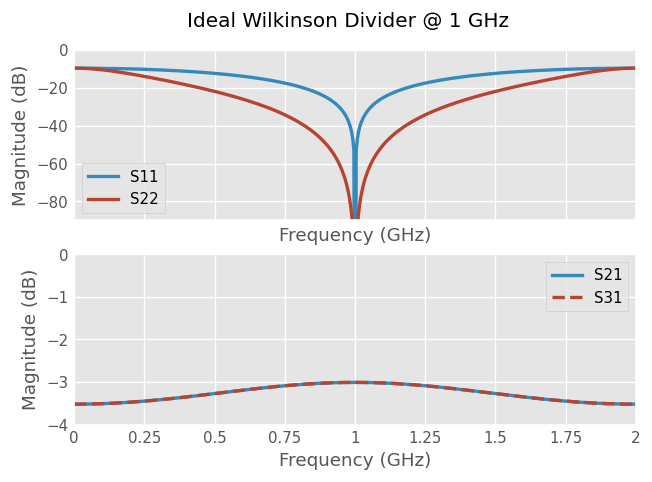

In [3]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
C.network.plot_s_db(ax=ax1, m=0, n=0,  lw=2)  # S11
C.network.plot_s_db(ax=ax1, m=1, n=1,  lw=2)  # S22
ax1.set_ylim(-90, 0)
C.network.plot_s_db(ax=ax2, m=1, n=0,  lw=2)  # S21
C.network.plot_s_db(ax=ax2, m=2, n=0,  ls='--', lw=2)  # S31
ax2.set_ylim(-4, 0)
fig.suptitle('Ideal Wilkinson Divider @ 1 GHz')

In [4]:
balanced_testN=C.network; balanced_testN

3-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j 50.+0.j 50.+0.j]

In [5]:
#dics to hold the split aprt .s3p measuere
p12set={}
p23set={}
p13set={}

for i, j in balanced_testN.port_tuples:
    #scikit-rf use 0 start indexing so uping to 1
    i+=1; j+=1
    #print(f'S{i}{j}')
    #p12
    if (i in [1,2]) and (j in [1,2]):
        #got to figur out a better slicing of ports then this
        exec(f"p12set['S{i}{j}']=balanced_testN.s{i}{j}")
    #p23
    if (i in [2,3]) and (j in [2,3]):
        exec(f"p23set['S{i}{j}']=balanced_testN.s{i}{j}")
    #p13
    if (i in [1,3]) and (j in [1,3]):
        exec(f"p13set['S{i}{j}']=balanced_testN.s{i}{j}")

print('p12set\n',p12set)
print('\np23set\n', p23set)
print('\n13set', p13set)

p12set
 {'S11': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S21': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S12': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S22': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j]}

p23set
 {'S22': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S32': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S23': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S33': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j]}

13set {'S11': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S31': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S13': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S33': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j]}


In [6]:
#orginal port names are dict keys from permutiton generation
#forcing all the ports to i,j in 1,2 to 
#look like port numbers from a typical 2p VNA
#that wont reindex when doing susseive s2p meassure for N>2 
#device meassure

new_port_names=['S11', 'S12', 'S21', 'S22']
p23_old_port_names=['S22', 'S23', 'S32', 'S33']
p13_old_port_names=['S13', 'S13', 'S31', 'S33']

#use dict comperhension to regen dict with i,j in 1,2
p23set={pnew:p23set[pold] for pnew, pold in zip(new_port_names, p23_old_port_names)}
p13set={pnew:p13set[pold] for pnew, pold in zip(new_port_names, p13_old_port_names)}


print('\np23set\n', p23set)
print('\n13set', p13set)


p23set
 {'S11': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S12': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S21': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S22': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j]}

13set {'S11': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S12': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S21': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j], 'S22': 1-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j]}


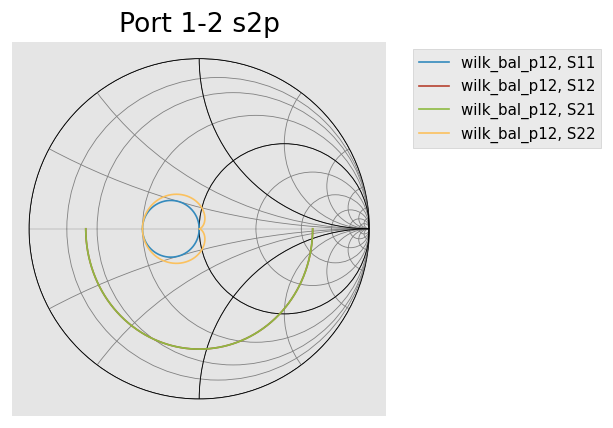

In [7]:
#binding the split up s1ps into a single s2p for each port set
p12set=rf.network.n_oneports_2_nport([p12set[i] for i in ['S11', 'S12', 'S21', 'S22']])
p12set.name='wilk_bal_p12'
p12set.plot_s_smith()
plt.title('Port 1-2 s2p')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


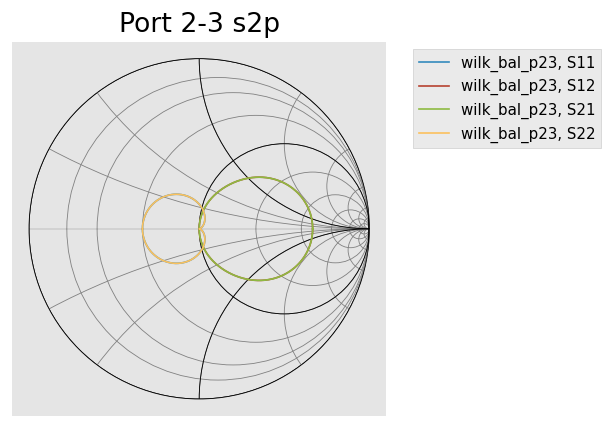

In [8]:
p23set=rf.network.n_oneports_2_nport([p23set[i] for i in ['S11', 'S12', 'S21', 'S22']])
p23set.name='wilk_bal_p23'
p23set.plot_s_smith()
plt.title('Port 2-3 s2p')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


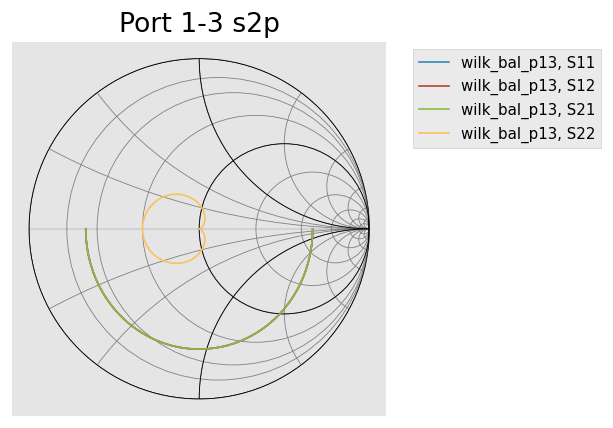

In [9]:
p13set=rf.network.n_oneports_2_nport([p13set[i] for i in ['S11', 'S12', 'S21', 'S22']])
p13set.name='wilk_bal_p13'
p13set.plot_s_smith()
plt.title('Port 1-3 s2p')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [10]:
#putting back togather the three pij s2ps into a single s3p
regen_balanced_testN=rf.network.n_twoports_2_nport([p12set, p23set, p13set], 3)
regen_balanced_testN.name='regened'
regen_balanced_testN

3-Port Network: 'regened',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j 50.+0.j 50.+0.j]

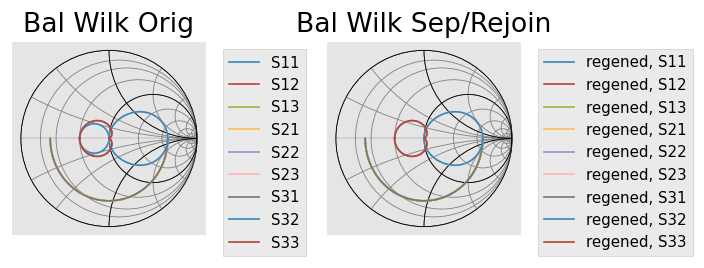

In [11]:
#quick plot of orginal vs regjoin
fig, [axorig, axnew]=plt.subplots(ncols=2, nrows=1)
balanced_testN.plot_s_smith(ax=axorig)
regen_balanced_testN.plot_s_smith(ax=axnew)

axorig.set_title('Bal Wilk Orig')
axorig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axnew.set_title('Bal Wilk Sep/Rejoin');
axnew.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

Looks like I skrewed up something in the seperation but this is just so I can get data test the real code aginest. Need to fix but for now will move on

In [12]:
#write the s2ps out 
p12set.write_touchstone(dir='./meassure_set/')
p23set.write_touchstone(dir='./meassure_set/')
p13set.write_touchstone(dir='./meassure_set/')

# Real code

In [13]:
#redowing the inport incase Andrew wants to make this standalone

In [14]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
rf.stylely(); 

/home/iridium/anaconda3/lib/python3.7/site-packages/skrf/plotting.py:1446: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  mpl.style.use(os.path.join(pwd, style_file))


In [15]:
class port2_MeassureJoin():
    """
    Class intended to read in a set of s2p files from a 2 port VNA meassument
    of a DUT with more then 2 port to then be joined into a single snp where n 
    is the highest number port
    
    Intended usage sequance: 
        - self.__init__
        - self.review_set
        - self.do_joint
        - self.review_joint
        - self.touchstone_result
    
    """
    
    def __init__(self, meassure_set_folder_path, base_name=''):
        """
        Class to read in a set of s2p's in a folder with a certian basename
        and join them into a single snp where n will be the highest port number.
        All measurments that are to be joined should have ther last three chars be 
        `pij` where i & j are the ports the s2p meassured and i<j.
        
        Args:
            meassure_set_folder_path (str): path to the folder where the
                set of snp measurments are to be joined. (Note: class was writen
                in linux and has not be tried on windows)
            
            base_name (str; ''): base name of the snp's files in the folder to pull in
             think of it like inclusinary glob. If left `''` will pull in all 
             snp's in the folder
            
        Returns:
            The networks read in are stored in to attriputes the fist
            is a dict containing each read in network: `self.networks`
            the second storage is a single scikit-rf network set of all the 
            read in networks: `self.network_set` that will only be made if 
            all the networks names pass the assertion to make sure they work with 
            `skrf.network.n_twoports_2_nport`
            
        
        TODO:
            - add assertion for only .s2p files
                
            
        """
        
        self.meassure_set_folder_path=meassure_set_folder_path
        self.base_name=base_name
        
        self.networks=rf.read_all(meassure_set_folder_path, base_name)
        
        #assertion check on .s2p file names
        for name in self.networks.keys():
            print(name)
            pi=name[-2]; pj=name[-1]
            print(name[-3]=='p', int(pi), int(pj))
            assert (name[-3]=='p') and pi.isdigit() and pj.isdigit() and (int(pi)<int(pj)), """
            each .snp file must have it's last 3 chars be `pij` where `i` and `j` 
            are intigers where i<j. ect: `*_p12.s2p`
            """

        
        self.network_set=rf.NetworkSet(self.networks, name=base_name+' set')
    
    def review_set(self, axs=None, return_axs=False):
        """
        Convinince method to plot the magnitude and phase uncertintys of the set
        networks that where read in to be jointed
        
        Args:
            axs (list of pyplot axis; None): exsisiting matplotlib axiss to append this methods
                plot to, if left None will create a new axis. The exspected
                axis order is [magnitde_plot_ax, phase_plot_ax]
            
            return_ax (bool; False): if true will return list axis that used to
                make plots in this method. The axis returned order will be [magnitde_plot_ax, phase_plot_ax]
                
        Returns:
            wll returns a mad & phase uncertinty plot of all networks in `self.network_set`
            If `return_ax` is True will also return axis used inside this method
        
        TODO:
            add table if passivity and the like to the side of the plot
        
        """
        
        if axs==None:
            fig, [ax_magUnc, ax_phaseUnc]=plt.subplots(nrows=2, sharex=True)
        else:
            assert len(axs)==2, 'there should only be two elements in axs'
            
            for i, ax in enumerate(axs):
                assert repr(type(ax))=="<class 'matplotlib.axes._subplots.AxesSubplot'>", f"element {i} in axs was not a matplotlib axis"
            ax_magUnc=axs[0]; ax_phaseUnc=axs[1]
            ax_magUnc.get_shared_x_axes().join(ax_magUnc, ax_phaseUnc)
        
        
        self.network_set.plot_uncertainty_bounds_s_db(ax=ax_magUnc)
        ax_magUnc.set_title('Magnitude Uncertainty')
        ax_magUnc.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        self.network_set.plot_uncertainty_bounds_s_deg_unwrap(ax=ax_phaseUnc)
        ax_phaseUnc.set_title('Phase(deg-unwrap) Uncertainty')
        ax_phaseUnc.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        fig.suptitle(f'Network Set Quick Overview: "{self.network_set.name}"')

        plt.tight_layout()
        
        if return_axs:
            return [ax_magUnc, ax_phaseUnc]
        
    def do_joint(self, new_name=None):
        """
        method that performs the joining of the set of networks read in into a single
        snp (see https://scikit-rf.readthedocs.io/en/latest/api/generated/skrf.network.n_twoports_2_nport.html#skrf.network.n_twoports_2_nport)
        
        Args:
            new_name (str; None): new name of the resulting joined network. If 
            left None will use `self.base_name` as new name
        
        Returns:
            creates a new joind snp in `self.joint_network`
        
        TODO:
            -figure out how to join s4ps togather since scikit-rf as of 20210130
            only does that for s2ps
            
        
        """
        
        self.joint_network=rf.network.n_twoports_2_nport(self.network_set, len(self.network_set))
        
        if new_name==None:
            self.joint_network.name=self.base_name
        else:
            self.joint_network.name=new_name
            
            
    def review_joint(self, ax=None, return_ax=False):
        """
        Convinince method to plot a smith chart of the resulting jointed
        network with all the S parmters on it. Will raise an assertion error
        if called before `self.do_joint` is ran
        
        Args:
            ax (pyplot axis; None): exsisiting matplotlib axis to append this methods
                plot to, if left None will create a new axis
            
            return_ax (bool; False): if true will return the axis that used to
                make plots in this method
                
        Returns:
            wll return a smith plot of all the S-parms in `self.joint_network`
            If `return_ax` is True will also return axis used inside this method
        
        TODO:
            add table if passivity and the like to the side of the plot
        
        """
        
        assert hasattr(self, 'joint_network'), "`self.joint_network` must exsist, try to create with `self.do_joint`"
        
        ax=ax or plt.gca()
        self.joint_network.plot_s_smith(ax=ax)
        ax.set_title(f'Joined s{self.joint_network.nports}p: {self.joint_network.name}')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        if return_ax:
            return ax        
        
        #look into doing something like https://stackoverflow.com/questions/30263627/python-pandas-summary-table-plot
        #for the is_passive, ect methods
        
    
    def touchstone_result(self):
        """
        method to write out the resultsing jointed snp network as a new .snp file
        the name of the file will be the name in `self.joint_network.name` (see
        `self.do_joint` and `self.__init__` to see how to set) and will be located where
        the orgianl folder read was at init. 
        
        Will throw assertion error if used before `self.do_joint` is ran
        
        Args:
            None
        
        Returns:
            writes .snp file where file name is `self.joint_network.name` and
            folder location is `self.meassure_set_folder_path`, and will overwrite
            any exsisting file at that location with that name
        
        TODO:
            - add exsisting file warning and overwrite handling
        
        
        """
        assert hasattr(self, 'joint_network'), "`self.joint_network` must exsist, try to create with `self.do_joint`"
        
        self.joint_network.write_touchstone(dir=self.meassure_set_folder_path)
        

In [16]:
#create the obj and tell it the folder and the base name to glob aginst
#to read in the files
test=port2_MeassureJoin('./meassure_set/', base_name='wilk')
#look at all the .snp files it read it
test.networks

wilk_bal_p12
True 1 2
wilk_bal_p13
True 1 3
wilk_bal_p23
True 2 3


{'wilk_bal_p12': 2-Port Network: 'wilk_bal_p12',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j 50.+0.j],
 'wilk_bal_p13': 2-Port Network: 'wilk_bal_p13',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j 50.+0.j],
 'wilk_bal_p23': 2-Port Network: 'wilk_bal_p23',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j 50.+0.j]}

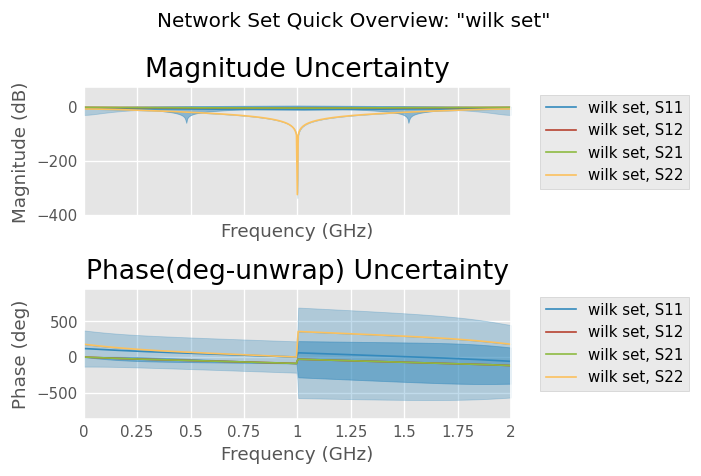

In [17]:
#quick look at the set of all the files it read in
test.review_set()

In [18]:
#join the set of files it read it and name the new joint set snp
test.do_joint(new_name='rejoin_test')
test.joint_network.name

'rejoin_test'

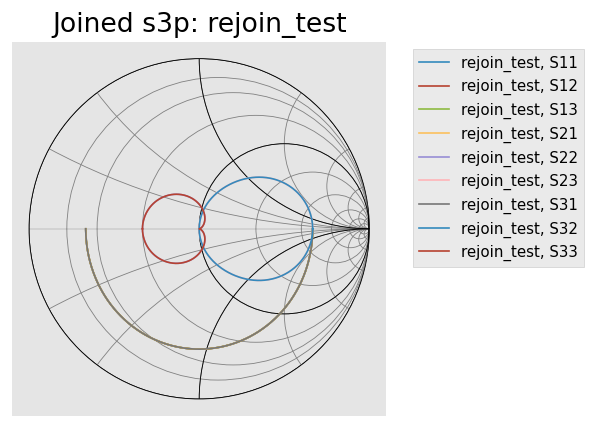

In [19]:
#quick vis of the resulting joint snp
test.review_joint()

just screwing around and looking at some basic network properties

In [20]:
test.joint_network.is_lossless()

False

In [21]:
test.joint_network.is_passive()

False

In [22]:
test.joint_network.is_reciprocal()

True

In [23]:
#test.joint_network.is_symmetric()
#only works for even number of ports network

In [24]:
#write out the created joint file
#will write to the directry it read the files from
#and scikit auto names a snp write based on what it has in that
#networks name attripute 
test.touchstone_result()

## compersion

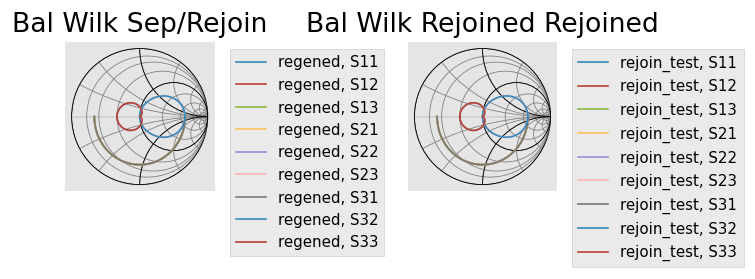

In [25]:
#quick plot of orginal vs regjoin
fig, [axorig, axnew]=plt.subplots(ncols=2, nrows=1)
regen_balanced_testN.plot_s_smith(ax=axorig)
test.joint_network.plot_s_smith(ax=axnew)

axorig.set_title('Bal Wilk Sep/Rejoin')
axorig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axnew.set_title('Bal Wilk Rejoined Rejoined');
axnew.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()